In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [2]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat'}

In [3]:
paths_to_burned_LAKE_output = ['bubbleflux_comparison/YKD-burned_bubble', 'bubbleflux_comparison/YKD-burned_nobubble']
paths_to_unburned_LAKE_output = ['bubbleflux_comparison/YKD-burned_bubble', 'bubbleflux_comparison/YKD-burned_nobubble']

In [4]:
path_to_unburned_co2_obs = '../data/raw/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/raw/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/raw/Pond_Env_For_Elchin.xlsx'

In [5]:
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date'])
min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()
burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['Date'])
min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [6]:
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
min_ch4_date = ch4_obs['date'].min()
max_ch4_date = ch4_obs['date'].max()

In [10]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    
    
    layers=pd.read_csv(os.path.join(out_path, datafile_names['layers']), delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['datetime'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = out_path.split('/')[-1]

    burned_layer_df.append(layers)

burned_layer_df = pd.concat(burned_layer_df)

In [11]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    
    
    layers=pd.read_csv(os.path.join(out_path, datafile_names['layers']), delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['datetime'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = out_path.split('/')[-1]

    unburned_layer_df.append(layers)

unburned_layer_df = pd.concat(unburned_layer_df)

In [12]:
#get temp, co2, and ch4 df for burned runs
burned_vars_df = []
for out_path in paths_to_burned_LAKE_output:
    #water temp
    twater=pd.read_csv(os.path.join(out_path, datafile_names['water_temp']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    twater.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water']
    twater['datetime'] = pd.to_datetime({'Year': twater['year'], 'Month': twater['month'], 'Day':twater['day']})

    #co2 concentration
    co2=pd.read_csv(os.path.join(out_path, datafile_names['co2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    co2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'co2_water']
    co2['datetime'] = pd.to_datetime({'Year': co2['year'], 'Month': co2['month'], 'Day':co2['day']})

    #ch4 concentration
    ch4=pd.read_csv(os.path.join(out_path, datafile_names['ch4_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    ch4.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'ch4_water']
    ch4['datetime'] = pd.to_datetime({'Year': ch4['year'], 'Month': ch4['month'], 'Day':ch4['day']})
    
    var_df = pd.merge(twater, co2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, ch4, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    
    var_df['run_name'] = out_path.split('/')[-1]
    burned_vars_df.append(var_df)

burned_vars_df = pd.concat(burned_vars_df)

In [13]:
#get temp, co2, and ch4 df for runs
unburned_vars_df = []
for out_path in paths_to_unburned_LAKE_output:
    #water temp
    twater=pd.read_csv(os.path.join(out_path, datafile_names['water_temp']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    twater.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water']
    twater['datetime'] = pd.to_datetime({'Year': twater['year'], 'Month': twater['month'], 'Day':twater['day']})

    #co2 concentration
    co2=pd.read_csv(os.path.join(out_path, datafile_names['co2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    co2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'co2_water']
    co2['datetime'] = pd.to_datetime({'Year': co2['year'], 'Month': co2['month'], 'Day':co2['day']})

    #ch4 concentration
    ch4=pd.read_csv(os.path.join(out_path, datafile_names['ch4_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    ch4.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'ch4_water']
    ch4['datetime'] = pd.to_datetime({'Year': ch4['year'], 'Month': ch4['month'], 'Day':ch4['day']})
    
    var_df = pd.merge(twater, co2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, ch4, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    
    var_df['run_name'] = out_path.split('/')[-1]
    unburned_vars_df.append(var_df)

unburned_vars_df = pd.concat(unburned_vars_df)

# Plotting
### Burned Plots

<Axes: xlabel='datetime', ylabel='t_water'>

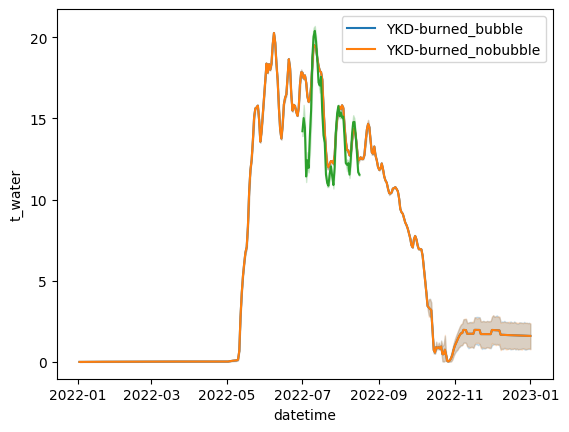

In [14]:
sns.lineplot(data= burned_vars_df[burned_vars_df['t_water']!=-999], x='datetime', y='t_water', hue = 'run_name')
sns.lineplot(data=burned_co2_obs, x='Date', y='WaterTemp_degC')

<Axes: xlabel='datetime', ylabel='co2_water'>

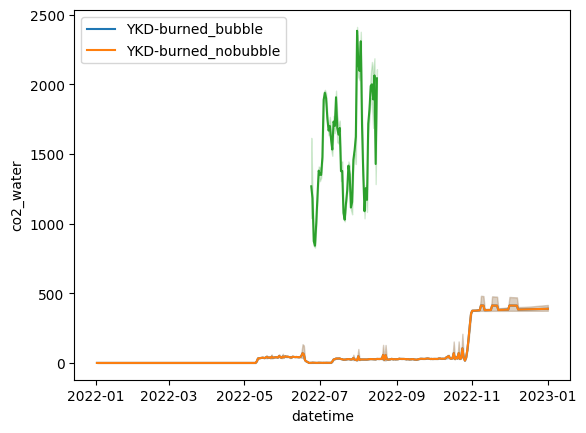

In [15]:
sns.lineplot(data= burned_vars_df[burned_vars_df['co2_water']!=-999], x='datetime', y='co2_water', hue = 'run_name')
sns.lineplot(data=burned_co2_obs, x='Date', y='CO2_High_ppm')

<Axes: xlabel='datetime', ylabel='ch4_water'>

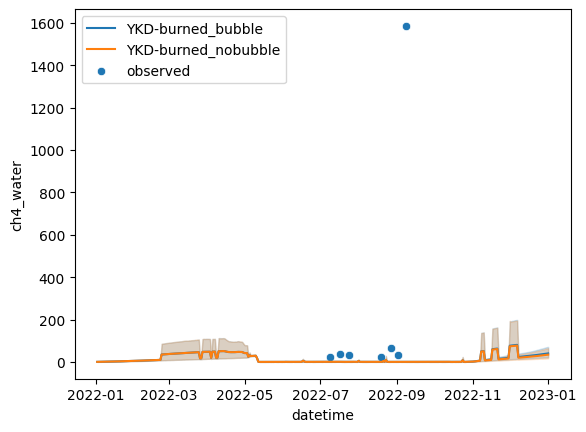

In [16]:
sns.lineplot(data= burned_vars_df[burned_vars_df['ch4_water']!=-999], x='datetime', y='ch4_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='date', y='CH4_ppm', label='observed')

### Unburned Plots

<Axes: xlabel='datetime', ylabel='t_water'>

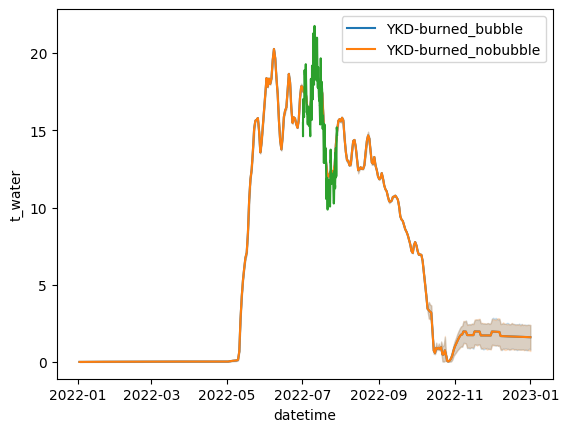

In [17]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['t_water']!=-999], x='datetime', y='t_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='WaterTemp_degC')

<Axes: xlabel='datetime', ylabel='co2_water'>

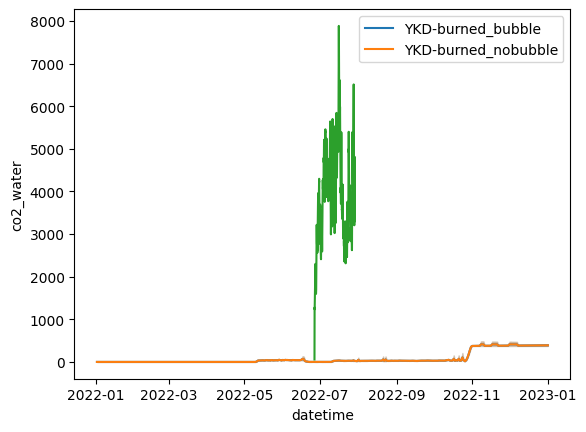

In [18]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['co2_water']!=-999], x='datetime', y='co2_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='CO2_High_ppm')

<Axes: xlabel='datetime', ylabel='ch4_water'>

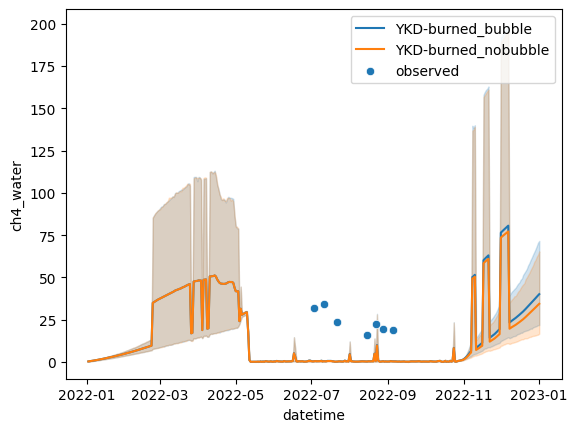

In [19]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['ch4_water']!=-999], x='datetime', y='ch4_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='date', y='CH4_ppm', label='observed')